# Loan Prediction

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv('./dataset/train.csv')
test_data = pd.read_csv('./dataset/test.csv')

In [3]:
train_data.shape

(614, 13)

In [4]:
test_data.shape

(367, 12)

#### Creating a backup file

In [5]:
train_data_og = train_data.copy()
test_data_og = test_data.copy()

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

In [7]:
train_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [8]:
test_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [9]:
train_data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [10]:
train_data.shape, test_data.shape

((614, 13), (367, 12))

In [11]:
train_data.Loan_Status.value_counts(normalize=True) # normalize help in normalizing the values

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

There isnt a good bal between our target which needs to be managed using ROS method or stratify

#### Visualising Categorical variables

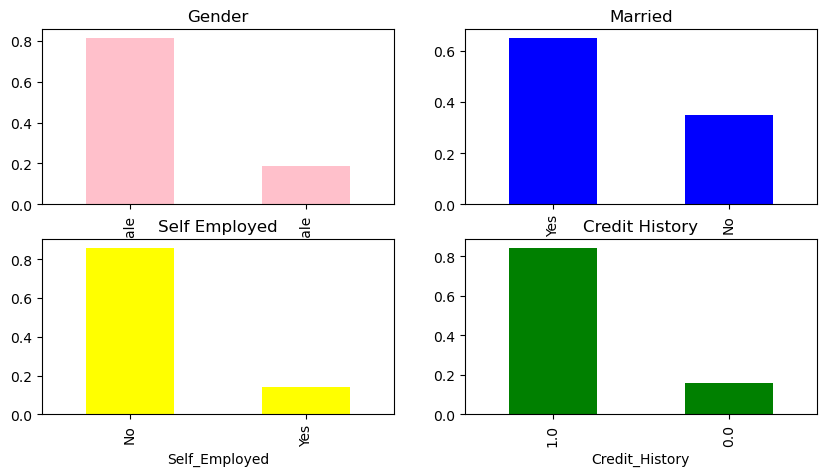

In [12]:
plt.figure(1)
plt.subplot(2,2,1)
train_data.Gender.value_counts(normalize=True).plot.bar(figsize=(10, 5), title="Gender", color="pink")
plt.subplot(2,2,2)
train_data.Married.value_counts(normalize=True).plot.bar(figsize=(10, 5), title="Married", color="blue")
plt.subplot(2,2,3)
train_data.Self_Employed.value_counts(normalize=True).plot.bar(figsize=(10, 5), title="Self Employed", color="yellow")
plt.subplot(2,2,4)
train_data.Credit_History.value_counts(normalize=True).plot.bar(figsize=(10, 5), title="Credit History", color="green")

plt.show()

Most loan Applicants are male, married and not self_employed with a 1.0 credit history

#### Visualising Ordinal variables

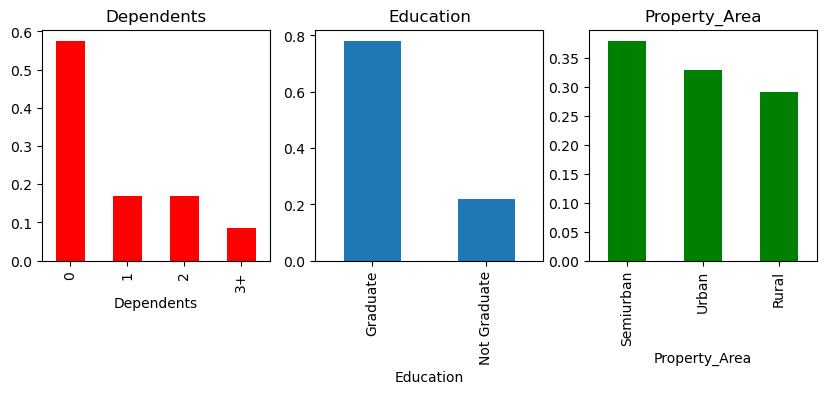

In [13]:
plt.figure(1)
plt.subplot(1,3,1)
train_data['Dependents'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Dependents',color='red')
plt.subplot(1,3,2)
train_data['Education'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Education')
plt.subplot(1,3,3)
train_data['Property_Area'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Property_Area',color='green')
plt.show()

Most applicants dont have dependents are graduates and belong from semiurban area

In [14]:
train_data['Dependents'] = train_data['Dependents'].replace('3+', '3')

#### Visualising Numeric Variables and checking for outliers

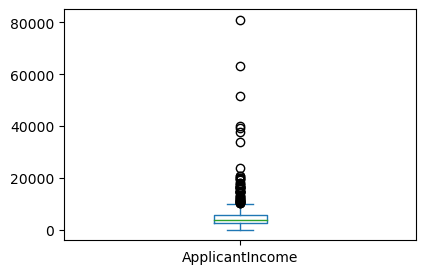

In [15]:
plt.figure(1)
plt.subplot(1,2,1)
# sns.distplot(train_data.ApplicantIncome)
# plt.subplot(1,2,2)
train_data.ApplicantIncome.plot.box(figsize=(10, 3))
plt.show()

We can observe that there is high left skewness in the applicant income which means there are outliers which needs to be treated before we build our model

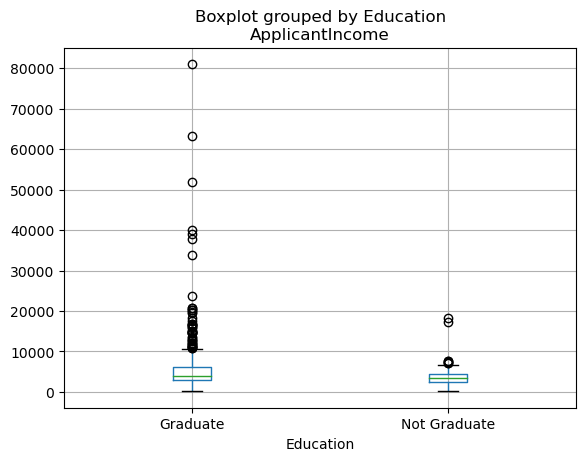

In [16]:
#Visualizing the application income considering whether applicant is graduate or not

train_data.boxplot(column="ApplicantIncome", by="Education")
plt.show()

We can observe that most anomalies are in case of Graduates compared to non graduates

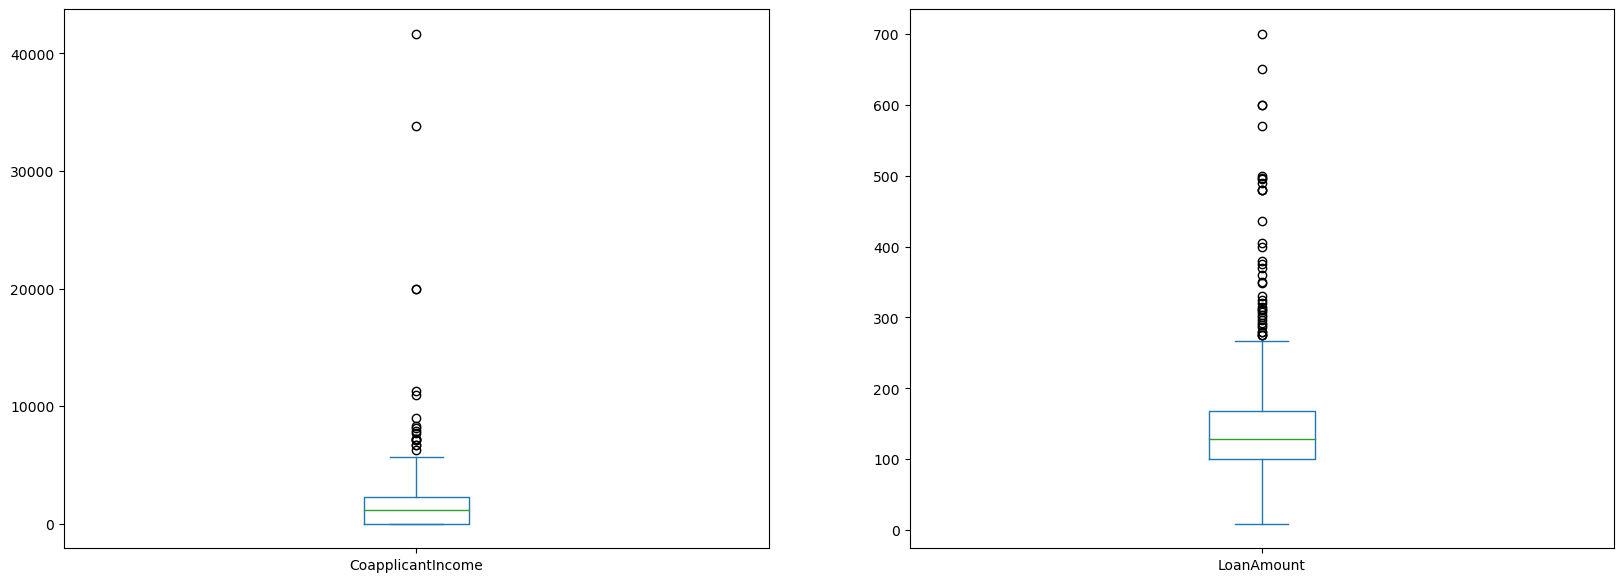

In [17]:
plt.figure(1)
plt.subplot(1,2,1)
train_data['CoapplicantIncome'].plot.box(figsize=(20,7))
plt.subplot(1,2,2)
train_data['LoanAmount'].plot.box()
plt.show()

#### Bivariate Analysis

<Figure size 640x480 with 0 Axes>

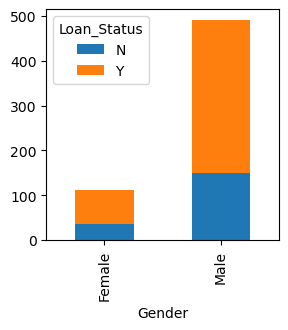

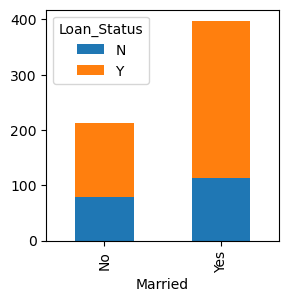

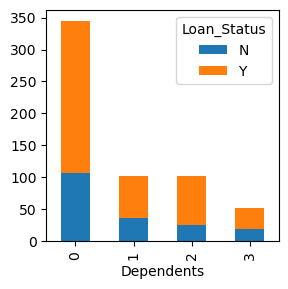

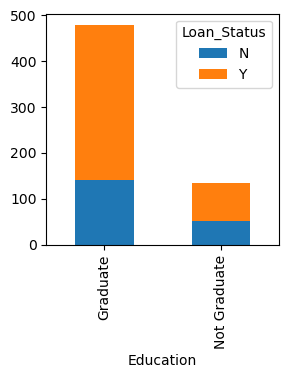

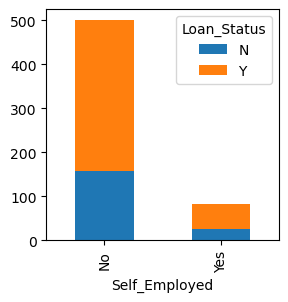

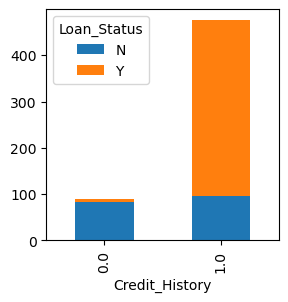

In [18]:
plt.figure(4)

gender = pd.crosstab(train_data.Gender, train_data.Loan_Status)
gender.plot.bar(stacked=True, figsize=(3,3))

married=pd.crosstab(train_data['Married'],train_data['Loan_Status'])
married.plot(kind='bar',stacked=True,figsize=(3,3))

dependents=pd.crosstab(train_data['Dependents'],train_data['Loan_Status'])
dependents.plot(kind='bar',stacked=True,figsize=(3,3))

education=pd.crosstab(train_data['Education'],train_data['Loan_Status'])
education.plot(kind='bar',stacked=True,figsize=(3,3))

selfemployed=pd.crosstab(train_data['Self_Employed'],train_data['Loan_Status'])
selfemployed.plot(kind='bar',stacked=True,figsize=(3,3))

credithistory=pd.crosstab(train_data['Credit_History'],train_data['Loan_Status'])
credithistory.plot(kind='bar',stacked=True,figsize=(3,3))

plt.show()

From the above visualisation its clear that mostly graduates, self-employed and applicants with 0 dependents have high chances of loan approval
Applicants whose credit history is 0 have very low chances of getting loan

In [19]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


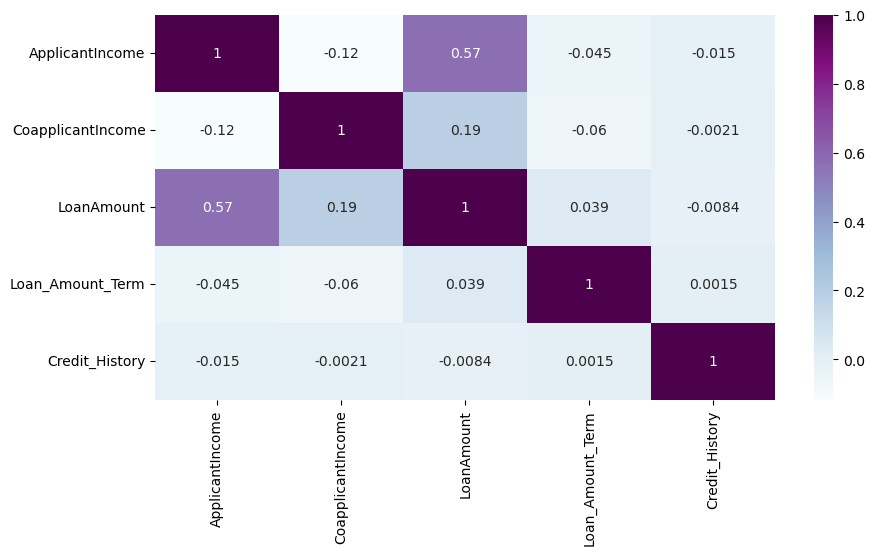

In [20]:
plt.figure(figsize=(10,5))

corr_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

sns.heatmap(train_data[corr_columns].corr(), cmap="BuPu", annot=True)
plt.show()

There's about 50% correlation between loan amount and applicant income